In [2]:
import time
from typing import Any, Callable, Tuple

import matplotlib.pyplot as plt
import numpy as np
from scipy.linalg import solve_continuous_are
from tqdm import tqdm
from IPython.display import HTML

from koopman.simulation.animation import PlotEnvironment
from koopman.simulation.systems import DynamicalSystem, Pendulum
from koopman.simulation.simulator import simulate
from spatialmath.base import angle_wrap

Simulation progress: 100%|██████████| 250/250 [00:00<00:00, 8009.35it/s]


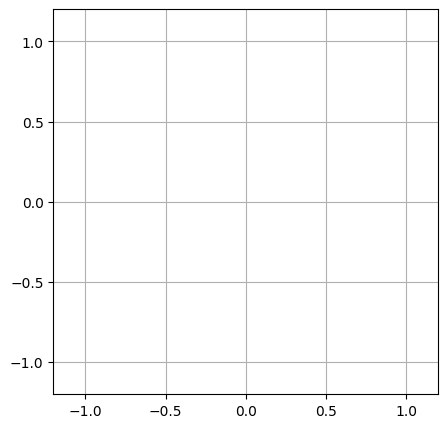

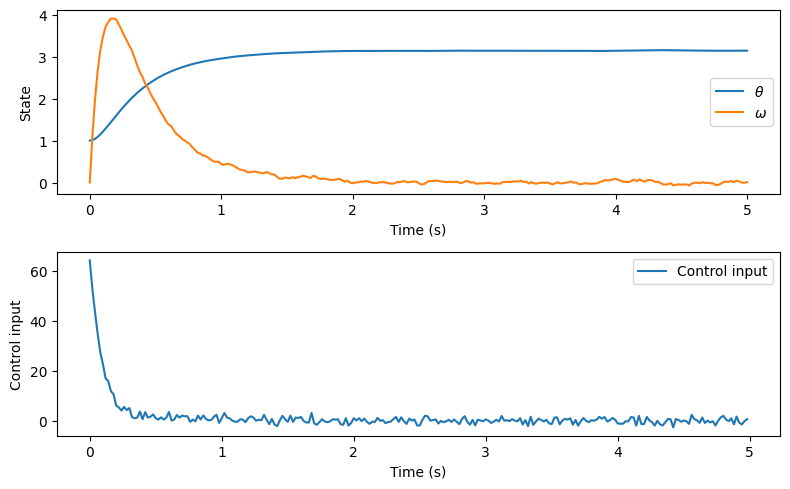

In [3]:
xd = np.array([np.pi, 0.0])  # Desired state
kp = np.diag([30.0, 10.0])

def control(t: float, x: np.ndarray) -> np.ndarray:
    """Control input for the pendulum system."""
    e = xd - x
    return np.array([np.sum(kp @ e)]) + np.random.normal(0, 1.0, size=(1,))


def simulate_pendulum():
    sys = Pendulum(Pendulum.Params(m=1, l=1, g=9.81, b=0.5))

    x0 = np.array([1.0, 0.0])
    tf = 5.0

    ts, xhist, uhist = simulate(sys, tf=tf, dt=0.02, u=control, x0=x0, log=True)

    # Render the simulation
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.grid(True)
    ax.set_aspect('equal')

    env = PlotEnvironment(fig, ax)
    env.add_element(Pendulum.PlotElement(env, sys))
    ani = env.render(t_range=(0, tf), fps=30)
    
    return ani, ts, xhist, uhist

ani, ts, xhist, uhist = simulate_pendulum()

fig, ax = plt.subplots(2, 1, figsize=(8, 5))
ax[0].plot(ts, xhist[:, 0], label=r'$\theta$')
ax[0].plot(ts, xhist[:, 1], label=r'$\omega$')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('State')
ax[0].legend()

ax[1].plot(ts[:-1], uhist, label='Control input')
ax[1].set_xlabel('Time (s)')
ax[1].set_ylabel('Control input')
ax[1].legend()
plt.tight_layout()
plt.show()

In [4]:
HTML(ani.to_html5_video())

(2, 200, 1)


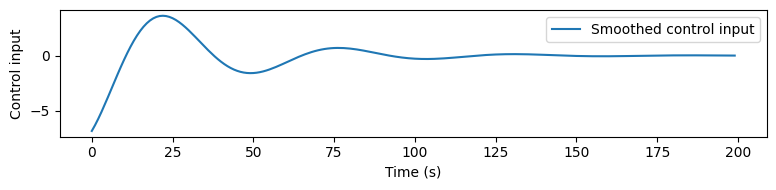

In [34]:
import numpy as np
from scipy.ndimage import uniform_filter1d, gaussian_filter1d

def generate_gaussian_smooth_controls(T, N=1, nu=1, std=1.0, sigma_range=[0.5, 2.0]):
    """
    Generate N smooth random control trajectories using a Gaussian filter.

    Parameters:
        T (int): Number of timesteps
        nu (int): Control dimension
        N (int): Number of trajectories
        std (float): Amplitude of noise
        sigma (float): Std of Gaussian kernel (controls smoothness)
        scale (float): Final scaling factor

    Returns:
        u (ndarray): Smooth controls, shape (N, T, nu)
    """
    freq_range=(1.0, 5.0)
    decay_range=(0.1, 10.0)
    amp_range=(1.0, 10.0)
    phase_range=(0, 2*np.pi)
    
    t = np.linspace(0, 1, T)  # time over 1 second

    # Random parameters per sample per channel
    freqs = np.random.uniform(*freq_range, size=(N, nu))
    decays = np.random.uniform(*decay_range, size=(N, nu))
    amps = np.random.uniform(*amp_range, size=(N, nu))
    phases = np.random.uniform(*phase_range, size=(N, nu))

    # Shape broadcasting to (N, T, nu)
    t = t[None, :, None]  # (1, T, 1)
    freqs = freqs[:, None, :]  # (N, 1, nu)
    decays = decays[:, None, :]
    amps = amps[:, None, :]
    phases = phases[:, None, :]

    signals = amps * np.exp(-decays * t) * np.sin(2 * np.pi * freqs * t + phases)
    return signals

T = 200
us = generate_gaussian_smooth_controls(T, nu=1, N=2, std=10.0, sigma_range=(2,10))
print(us.shape)

fig, ax = plt.subplots(1,1, figsize=(8, 2))
ax.plot(us[0, ...], label='Smoothed control input')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Control input')
ax.legend()
plt.tight_layout()
plt.show()

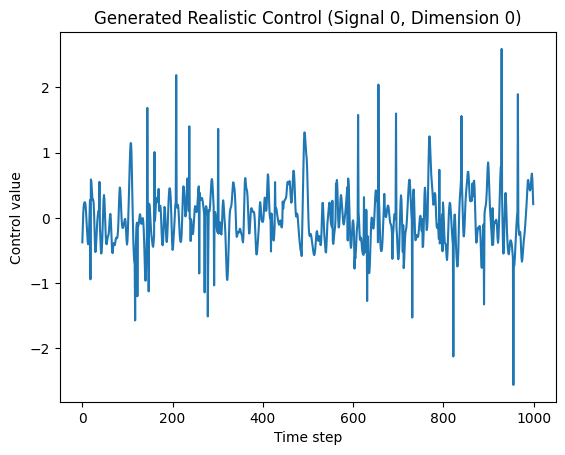

In [4]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

def generate_realistic_controls(T, N=1, nu=1,
                                base_std=1.0, sigma_range=[0.5, 2.0],
                                switch_prob=0.05, switch_magnitude=2.0):
    """
    Generate control signals combining smooth trends with intermittent fast switching events.
    
    Parameters:
        T (int): Number of time steps.
        N (int): Number of control signals (batch size).
        nu (int): Number of control dimensions.
        base_std (float): Standard deviation for the base random signal.
        sigma_range (list): Range for the Gaussian smoothing sigma [min, max].
        switch_prob (float): Probability of a fast switching event at any time step.
        switch_magnitude (float): Maximum magnitude for the switching jump.
        
    Returns:
        u_realistic (np.ndarray): Array of shape (N, T, nu) containing the generated controls.
    """
    
    # 1. Generate smooth base controls
    u_raw = np.random.randn(N, T, nu) * base_std
    u_smooth = np.zeros_like(u_raw)
    sigmas = np.random.uniform(sigma_range[0], sigma_range[1], size=(N,))
    
    for n in range(N):
        for i in range(nu):
            u_smooth[n, :, i] = gaussian_filter1d(u_raw[n, :, i], sigma=sigmas[n], mode="nearest")
    
    # 2. Generate fast switching events
    switch_signal = np.zeros_like(u_smooth)
    for n in range(N):
        for i in range(nu):
            # For each time step, decide if a switch event occurs
            for t in range(T):
                if np.random.rand() < switch_prob:
                    # Instantaneous jump added. You can also consider other distributions for the jump.
                    switch_signal[n, t, i] = np.random.uniform(-switch_magnitude, switch_magnitude)
            # Optionally, apply a very short smoothing to simulate a fast (but not infinitely fast) transition.
            switch_signal[n, :, i] = gaussian_filter1d(switch_signal[n, :, i], sigma=0.2, mode="nearest")
    
    # 3. Combine the smooth base with the switching events
    u_realistic = u_smooth + switch_signal
    return u_realistic

# Example usage:
T = 1000        # number of time steps
N = 3           # number of control signals in a batch
nu = 2          # number of control dimensions (e.g., a 2D input)

controls = generate_realistic_controls(T, N, nu,
                                        base_std=1.0, sigma_range=[0.5, 2.0],
                                        switch_prob=0.05, switch_magnitude=2.0)

# To visualize the generated controls for the first signal and first dimension:
import matplotlib.pyplot as plt
plt.plot(controls[0, :, 0])
plt.title("Generated Realistic Control (Signal 0, Dimension 0)")
plt.xlabel("Time step")
plt.ylabel("Control value")
plt.show()
